# Deep Colorization

This notebook creates a model that is able to colorize images to a certain extent, combining a deep Convolutional Neural Network architecture. The dataset to be used for the training is MS-COCO.

This notebook is getting original implementation in https://github.com/titu1994/keras-mobile-colorizer to ipynb. There would a sepearate notebook with improvements to above mentioned implementation.

### Install required modules

In [15]:
# %%capture capt

# Install pip packages in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install pydot
!{sys.executable} -m pip install scikit-image
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install hazm

### Get Data

In [0]:
import os
from os.path import isfile, isdir
from tqdm import tqdm
from urllib.request import urlretrieve
import zipfile


if not os.path.exists('dataset/'):
    os.makedirs('dataset/')

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

def download_and_save(url):
    zip_path = 'dataset/' + url[url.rfind("/") + 1:]
    path = zip_path[:-4]
    if not isdir(path): # True: # 
        with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc=path) as pbar:
            urlretrieve(url, zip_path, pbar.hook)
        print("Extracting content from Zip file")
        zip_ref = zipfile.ZipFile(zip_path, 'r')
        zip_ref.extractall('dataset/')
        zip_ref.close() 
        print("Extraction Complete")
    if os.path.exists(zip_path):
        os.remove(zip_path) # Remove zip file
    return path

# Updated Image Paths
TRAIN_IMAGE_PATH = "dataset/train2014"
VALIDATION_IMAGE_PATH = "dataset/val2014"

In [0]:
# Download MS-COCO Dataset
download_and_save("http://images.cocodataset.org/zips/train2014.zip")
download_and_save("http://images.cocodataset.org/zips/val2014.zip")

### data_utils.py

In [0]:
import numpy as np
import os
import glob

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave, imread

import tensorflow as tf
from tensorflow import data as tfdata
sess = tf.Session()

from keras import backend as K
K.set_session(sess)

sess = None

from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.models import Model

IMAGE_SIZE = 128  # Global constant image size
EMBEDDING_IMAGE_SIZE = 224  # Global constant embedding size

TRAIN_RECORDS_PATH = "data/images.tfrecord"  # local path to tf record directory
VAL_RECORDS_PATH = "data/val_images.tfrecord"  # local path to tf record directory


if not os.path.exists('weights/'):
    os.makedirs('weights/')

if not os.path.exists('results/'):
    os.makedirs('results/')

if not os.path.exists('data/'):
    os.makedirs('data/')

feature_extraction_model = None
mobilenet_activations = None

def _load_mobilenet():
    global feature_extraction_model, mobilenet_activations

    # Feature extraction module
    feature_extraction_model = MobileNet(input_shape=(EMBEDDING_IMAGE_SIZE, EMBEDDING_IMAGE_SIZE, 3),
                                         alpha=1.0,
                                         depth_multiplier=1,
                                         include_top=True,
                                         weights='imagenet')

    # Set it up so that we can do inference on MobileNet without training it by mistake
    feature_extraction_model.graph = tf.get_default_graph()
    feature_extraction_model.trainable = False

    # Get the pre-softmax activations from MobileNet
    mobilenet_activations = Model(feature_extraction_model.input, feature_extraction_model.layers[-3].output)
    mobilenet_activations.trainable = False


def _get_pre_activations(grayscale_image, batchsize=100):
    # batchwise retrieve feature map from last layer - pre softmax
    activations = mobilenet_activations.predict(grayscale_image, batch_size=batchsize)
    return activations


def _extract_features(grayscaled_rgb, batchsize=100):
    # Load up MobileNet only when necessary, not during training
    if feature_extraction_model is None:
        _load_mobilenet()

    grayscaled_rgb_resized = []

    for i in grayscaled_rgb:
        # Resize to size of MobileNet Input
        i = resize(i, (EMBEDDING_IMAGE_SIZE, EMBEDDING_IMAGE_SIZE, 3), mode='constant')
        grayscaled_rgb_resized.append(i)

    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized) * 255.  # scale to 0-255 range for MobileNet preprocess_input
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)

    with feature_extraction_model.graph.as_default():  # using the shared graph of Colorization model and MobileNet
        features = _get_pre_activations(grayscaled_rgb_resized, batchsize)  # batchwise get the feature maps
        features = features.reshape((-1, 1000))

    return features


def _float32_feature_list(floats):
    return tf.train.Feature(float_list=tf.train.FloatList(value=floats))

def _generate_records(images_path, tf_record_name, batch_size=100):
    '''
    Creates a TF Record containing the pre-processed image consisting of
    1)  L channel input
    2)  ab channels output
    3)  features extracted from MobileNet
    This step is crucial for speed during training, as the major bottleneck
    is the extraction of feature maps from MobileNet. It is slow, and inefficient.
    '''
    if os.path.exists(tf_record_name):
        print("****  Delete old TF Records first! ****")
        exit(0)

    files = glob.glob(images_path + "/*.jpg")
    files = sorted(files)
    nb_files = len(files)

    # Use ZLIB compression to save space and create a TFRecordWriter
    options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.ZLIB)
    writer = tf.python_io.TFRecordWriter(tf_record_name, options)

    size = max(EMBEDDING_IMAGE_SIZE, IMAGE_SIZE)  # keep larger size until stored in TF Record

    X_buffer = []
    for i, fn in enumerate(files):
        try:  # prevent crash due to corrupted imaged
            X = imread(fn)
            X = resize(X, (size, size, 3), mode='constant') # resize to the larger size for now
        except:
            continue

        X_buffer.append(X)

        if len(X_buffer) >= batch_size:
            X_buffer = np.array(X_buffer)
            _serialize_batch(X_buffer, writer, batch_size)  # serialize the image into the TF Record

            del X_buffer  # delete buffered images from memory
            X_buffer = []  # reset to new list

            print("Processed %d / %d images" % (i + 1, nb_files))

    if len(X_buffer) != 0:
        X_buffer = np.array(X_buffer)
        _serialize_batch(X_buffer, writer)  # serialize the remaining images in buffer

        del X_buffer  # delete buffer

    print("Processed %d / %d images" % (nb_files, nb_files))
    print("Finished creating TF Record")

    writer.close()


def _serialize_batch(X, writer, batch_size=100):
    '''
    Processes a batch of images, and then serializes into the TFRecord
    Args:
        X: original image with no preprocessing
        writer: TFRecordWriter
        batch_size: batch size
    '''
    [X_batch, features], Y_batch = _process_batch(X, batch_size)  # preprocess batch

    for j, (img_l, embed, y) in enumerate(zip(X_batch, features, Y_batch)):
        # resize the images to their smaller size to reduce space wastage in the record
        img_l = resize(img_l, (IMAGE_SIZE, IMAGE_SIZE, 1), mode='constant')
        y = resize(y, (IMAGE_SIZE, IMAGE_SIZE, 2), mode='constant')

        example_dict = {
            'image_l': _float32_feature_list(img_l.flatten()),
            'image_ab': _float32_feature_list(y.flatten()),
            'image_features': _float32_feature_list(embed.flatten())
        }
        example_feature = tf.train.Features(feature=example_dict)
        example = tf.train.Example(features=example_feature)
        writer.write(example.SerializeToString())


def _construct_dataset(record_path, batch_size, sess):
    def parse_record(serialized_example):
        # parse a single record
        features = tf.parse_single_example(
            serialized_example,
            features={
                'image_l': tf.FixedLenFeature([IMAGE_SIZE, IMAGE_SIZE, 1], tf.float32),
                'image_ab': tf.FixedLenFeature([IMAGE_SIZE, IMAGE_SIZE, 2], tf.float32),
                'image_features': tf.FixedLenFeature([1000, ], tf.float32)
            })

        l, ab, embed = features['image_l'], features['image_ab'], features['image_features']
        return l, ab, embed

    dataset = tfdata.TFRecordDataset([record_path], 'ZLIB')  # create a Dataset to wrap the TFRecord
    dataset = dataset.map(parse_record, num_parallel_calls=2)  # parse the record
    dataset = dataset.repeat()  # repeat forever
    dataset = dataset.batch(batch_size)  # batch into the required batchsize
    dataset = dataset.shuffle(buffer_size=5)  # shuffle the batches
    iterator = dataset.make_initializable_iterator()  # get an iterator over the dataset

    sess.run(iterator.initializer)  # initialize the iterator
    next_batch = iterator.get_next()  # get the iterator Tensor

    return dataset, next_batch


def _process_batch(X, batchsize=100):
    '''
    Process a batch of images for training
    Args:
        X: a RGB image
    '''
    grayscaled_rgb = gray2rgb(rgb2gray(X))  # convert to 3 channeled grayscale image
    lab_batch = rgb2lab(X)  # convert to LAB colorspace
    X_batch = lab_batch[:, :, :, 0]  # extract L from LAB
    X_batch = X_batch.reshape(X_batch.shape + (1,))  # reshape into (batch, IMAGE_SIZE, IMAGE_SIZE, 1)
    X_batch = 2 * X_batch / 100 - 1.  # normalize the batch
    Y_batch = lab_batch[:, :, :, 1:] / 127  # extract AB from LAB
    features = _extract_features(grayscaled_rgb, batchsize)  # extract features from the grayscale image

    return ([X_batch, features], Y_batch)


def generate_train_records(batch_size=100):
    _generate_records(TRAIN_IMAGE_PATH, TRAIN_RECORDS_PATH, batch_size)


def generate_validation_records(batch_size=100):
    _generate_records(VALIDATION_IMAGE_PATH, VAL_RECORDS_PATH, batch_size)


def train_generator(batch_size):
    '''
    Generator which wraps a tf.data.Dataset object to read in the
    TFRecord more conveniently.
    '''
    if not os.path.exists(TRAIN_RECORDS_PATH):
        print("\n\n", '*' * 50, "\n")
        print("Please create the TFRecord of this dataset by running `data_utils.py` script")
        exit(0)

    with tf.Session() as train_gen_session:
        dataset, next_batch = _construct_dataset(TRAIN_RECORDS_PATH, batch_size, train_gen_session)

        while True:
            try:
                l, ab, features = train_gen_session.run(next_batch)  # retrieve a batch of records
                yield ([l, features], ab)
            except:
                # if it crashes due to some reason
                iterator = dataset.make_initializable_iterator()
                train_gen_session.run(iterator.initializer)
                next_batch = iterator.get_next()

                l, ab, features = train_gen_session.run(next_batch)
                yield ([l, features], ab)


def val_batch_generator(batch_size):
    '''
    Generator which wraps a tf.data.Dataset object to read in the
    TFRecord more conveniently.
    '''
    if not os.path.exists(VAL_RECORDS_PATH):
        print("\n\n", '*' * 50, "\n")
        print("Please create the TFRecord of this dataset by running `data_utils.py` script with validation data")
        exit(0)

    with tf.Session() as val_generator_session:
        dataset, next_batch = _construct_dataset(VAL_RECORDS_PATH, batch_size, val_generator_session)

        while True:
            try:
                l, ab, features = val_generator_session.run(next_batch)  # retrieve a batch of records
                yield ([l, features], ab)
            except:
                # if it crashes due to some reason
                iterator = dataset.make_initializable_iterator()
                val_generator_session.run(iterator.initializer)
                next_batch = iterator.get_next()

                l, ab, features = val_generator_session.run(next_batch)
                yield ([l, features], ab)


def prepare_input_image_batch(X, batchsize=100):
    '''
    This is a helper function which does the same as _preprocess_batch,
    but it is meant to be used with images during testing, not training.
    Args:
        X: A grayscale image
    '''
    X_processed = X / 255.  # normalize grayscale image
    X_grayscale = gray2rgb(rgb2gray(X_processed))
    X_features = _extract_features(X_grayscale, batchsize)
    X_lab = rgb2lab(X_grayscale)[:, :, :, 0]
    X_lab = X_lab.reshape(X_lab.shape + (1,))
    X_lab = 2 * X_lab / 100 - 1.

    return X_lab, X_features


def postprocess_output(X_lab, y, image_size=None):
    '''
    This is a helper function for test time to convert and save the
    the processed image into the 'results' directory.
    Args:
        X_lab: L channel extracted from the grayscale image
        y: AB channels predicted by the colorizer network
        image_size: output image size
    '''
    y *= 127.  # scale the predictions to [-127, 127]
    X_lab = (X_lab + 1) * 50.  # scale the L channel to [0, 100]

    image_size = IMAGE_SIZE if image_size is None else image_size  # set a default image size if needed

    for i in range(len(y)):
        cur = np.zeros((image_size, image_size, 3))
        cur[:, :, 0] = X_lab[i, :, :, 0]
        cur[:, :, 1:] = y[i]
        imsave("results/img_%d.png" % (i + 1), lab2rgb(cur))

        if i % (len(y) // 20) == 0:
            print("Finished processing %0.2f percentage of images" % (i / float(len(y)) * 100))

### Generate TFRecords for training and validation dataset

In [0]:
from google.colab import files
import os
import shutil

# Generate the train tf record file
generate_train_records(batch_size=200)

# Generate the validation tf record file
generate_validation_records(batch_size=100)

# Remove Raw Training data and download Validation Data
if os.path.exists("dataset/"):
    shutil.rmtree('dataset/')

### Upload TFRecord to the Google Drive

In [5]:
import sys
!{sys.executable} -m pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a training file.
if os.path.exists(TRAIN_RECORDS_PATH):
    uploaded = drive.CreateFile({'title': 'images.tfrecord'})
    uploaded.SetContentFile(VAL_RECORDS_PATH)
    uploaded.Upload()

if os.path.exists(VAL_RECORDS_PATH):
    uploaded = drive.CreateFile({'title': 'val_images.tfrecord'})
    uploaded.SetContentFile(VAL_RECORDS_PATH)
    uploaded.Upload()

FileNotFoundError: ignored

### Download TFRecord in environment if not available

In [0]:
import requests

def download_and_save_tfrecord(path, url):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc=path) as pbar:
        urlretrieve(url, path, pbar.hook)

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768
        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

# Download TFRecord from the Google Drive
if not os.path.exists(TRAIN_RECORDS_PATH):
    download_file_from_google_drive("1DtW-secVk2-QdL1vUGgEPc3iL8T9CEnF", TRAIN_RECORDS_PATH) # Training dataset google file id

if not os.path.exists(VAL_RECORDS_PATH):
    download_file_from_google_drive("1Gf6qtUGkk_yYiMffn1a1_8GzxJcQjv6k", VAL_RECORDS_PATH) # Validation dataset google file id

In [20]:
import os

# Print size of the files
if os.path.exists(TRAIN_RECORDS_PATH):
    print("{} has size {} MB".format(TRAIN_RECORDS_PATH, os.stat(TRAIN_RECORDS_PATH).st_size / 1024 / 1024))

if os.path.exists(VAL_RECORDS_PATH):
    print("{} has size {} MB".format(VAL_RECORDS_PATH, os.stat(VAL_RECORDS_PATH).st_size / 1024 / 1024))

data/images.tfrecord has size 14381.601808547974 MB
data/val_images.tfrecord has size 7040.7601499557495 MB


### model_utils.py

In [0]:
from keras.layers import Conv2D, Input, Reshape, RepeatVector, concatenate, UpSampling2D, Flatten, Conv2DTranspose
from keras.models import Model

from keras import backend as K
from keras.losses import mean_squared_error
from keras.optimizers import Adam

mse_weight = 1.0 #1e-3

# set these to zeros to prevent learning
perceptual_weight = 1. / (2. * 128. * 128.) # scaling factor
attention_weight = 1.0 # 1.0


# shows the minimum value of the AB channels
def y_true_min(yt, yp):
    return K.min(yt)


# shows the maximum value of the RGB AB channels
def y_true_max(yt, yp):
    return K.max(yt)


# shows the minimum value of the predicted AB channels
def y_pred_min(yt, yp):
    return K.min(yp)


# shows the maximum value of the predicted AB channels
def y_pred_max(yt, yp):
    return K.max(yp)


def gram_matrix(x):
    assert K.ndim(x) == 4

    with K.name_scope('gram_matrix'):
        if K.image_data_format() == "channels_first":
            batch, channels, width, height = K.int_shape(x)
            features = K.batch_flatten(x)
        else:
            batch, width, height, channels = K.int_shape(x)
            features = K.batch_flatten(K.permute_dimensions(x, (0, 3, 1, 2)))

        gram = K.dot(features, K.transpose(features)) # / (channels * width * height)
    return gram


def l2_norm(x):
    return K.sqrt(K.sum(K.square(x)))


def attention_vector(x):
    if K.image_data_format() == "channels_first":
        batch, channels, width, height = K.int_shape(x)
        filters = K.batch_flatten(K.permute_dimensions(x, (1, 0, 2, 3)))  # (channels, batch*width*height)
    else:
        batch, width, height, channels = K.int_shape(x)
        filters = K.batch_flatten(K.permute_dimensions(x, (3, 0, 1, 2)))  # (channels, batch*width*height)

    filters = K.mean(K.square(filters), axis=0)  # (batch*width*height,)
    filters = filters / l2_norm(filters)  # (batch*width*height,)
    return filters


def total_loss(y_true, y_pred):
    mse_loss = mse_weight * mean_squared_error(y_true, y_pred)
    perceptual_loss = perceptual_weight * K.sum(K.square(gram_matrix(y_true) - gram_matrix(y_pred)))
    attention_loss = attention_weight * l2_norm(attention_vector(y_true) - attention_vector(y_pred))

    return mse_loss + perceptual_loss + attention_loss


def generate_mobilenet_model(lr=1e-3, img_size=128):
    '''
    Creates a Colorizer model. Note the difference from the report
    - https://github.com/baldassarreFe/deep-koalarization/blob/master/report.pdf

    I use a long skip connection network to speed up convergence and
    boost the output quality.
    '''
    # encoder model
    encoder_ip = Input(shape=(img_size, img_size, 1))
    encoder1 = Conv2D(64, (3, 3), padding='same', activation='relu', strides=(2, 2))(encoder_ip)
    encoder = Conv2D(128, (3, 3), padding='same', activation='relu')(encoder1)
    encoder2 = Conv2D(128, (3, 3), padding='same', activation='relu', strides=(2, 2))(encoder)
    encoder = Conv2D(256, (3, 3), padding='same', activation='relu')(encoder2)
    encoder = Conv2D(256, (3, 3), padding='same', activation='relu', strides=(2, 2))(encoder)
    encoder = Conv2D(512, (3, 3), padding='same', activation='relu')(encoder)
    encoder = Conv2D(512, (3, 3), padding='same', activation='relu')(encoder)
    encoder = Conv2D(256, (3, 3), padding='same', activation='relu')(encoder)

    # input fusion
    # Decide the image shape at runtime to allow prediction on
    # any size image, even if training is on 128x128
    batch, height, width, channels = K.int_shape(encoder)

    mobilenet_features_ip = Input(shape=(1000,))
    fusion = RepeatVector(height * width)(mobilenet_features_ip)
    fusion = Reshape((height, width, 1000))(fusion)
    fusion = concatenate([encoder, fusion], axis=-1)
    fusion = Conv2D(256, (1, 1), padding='same', activation='relu')(fusion)

    # decoder model
    decoder = Conv2D(128, (3, 3), padding='same', activation='relu')(fusion)
    decoder = UpSampling2D()(decoder)
    #decoder = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu')(decoder)
    decoder = concatenate([decoder, encoder2], axis=-1)
    decoder = Conv2D(64, (3, 3), padding='same', activation='relu')(decoder)
    decoder = Conv2D(64, (3, 3), padding='same', activation='relu')(decoder)
    decoder = UpSampling2D()(decoder)
    #decoder = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu')(decoder)
    decoder = concatenate([decoder, encoder1], axis=-1)
    decoder = Conv2D(32, (3, 3), padding='same', activation='relu')(decoder)
    decoder = Conv2DTranspose(2, (4, 4), strides=(2, 2), padding='same', activation='tanh')(decoder)
    # decoder = Conv2D(2, (3, 3), padding='same', activation='tanh')(decoder)
    # decoder = UpSampling2D((2, 2))(decoder)

    model = Model([encoder_ip, mobilenet_features_ip], decoder, name='Colorizer')
    model.compile(optimizer=Adam(lr), loss=total_loss, metrics=[y_true_max,
                                                                y_true_min,
                                                                y_pred_max,
                                                                y_pred_min])

    print("Colorization model built and compiled")
    return model    

In [23]:
model = generate_mobilenet_model()
model.summary()

from keras.utils.vis_utils import plot_model

# plot_model(model, to_file='skip_model.png', show_shapes=True)

Colorization model built and compiled
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 64, 64, 64)   640         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 64, 64, 128)  73856       conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 32, 32, 128)  147584      conv2d_28[0][0]                  
_______________________________________________________________________

### train_utils.py

In [0]:
from keras.callbacks import TensorBoard
import tensorflow as tf

'''
Below is a modification to the TensorBoard callback to perform 
batchwise writing to the tensorboard, instead of only at the end
of the batch.
'''
class TensorBoardBatch(TensorBoard):
    def __init__(self, *args, **kwargs):
        super(TensorBoardBatch, self).__init__(*args)

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}

        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.writer.add_summary(summary, batch)

        self.writer.flush()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.writer.add_summary(summary, epoch * self.batch_size)

        self.writer.flush()

### train_mobilenet.py

In [25]:
import os

from keras.callbacks import ModelCheckpoint

nb_train_images = 60000  # there are 82783 images in MS-COCO, set this to how many samples you want to train on.
batch_size = 125

model = generate_mobilenet_model(lr=1e-3)
model.summary()

WEIGHT_FILE_NAME = 'weights/mobilenet_model.h5'
EPOCHS = 2

# Continue training if weights are available
if os.path.exists(WEIGHT_FILE_NAME):
    model.load_weights(WEIGHT_FILE_NAME)

# Use Batchwise TensorBoard callback
tensorboard = TensorBoardBatch(batch_size=batch_size)
checkpoint = ModelCheckpoint(WEIGHT_FILE_NAME, monitor='loss', verbose=1,
                             save_best_only=True, save_weights_only=True)
callbacks = [checkpoint, tensorboard]

# Training model
model.fit_generator(generator=train_generator(batch_size),
                    steps_per_epoch=nb_train_images // batch_size,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=val_batch_generator(batch_size),
                    validation_steps=1
                    )

Colorization model built and compiled
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 64, 64, 64)   640         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 64, 64, 128)  73856       conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 32, 32, 128)  147584      conv2d_41[0][0]                  
_______________________________________________________________________

480/480 [==============================] - 364s 758ms/step - loss: 16511.0368 - y_true_max: 0.7210 - y_true_min: -0.7106 - y_pred_max: 0.9529 - y_pred_min: -0.9456 - val_loss: 8238.8809 - val_y_true_max: 0.7091 - val_y_true_min: -0.6952 - val_y_pred_max: 1.0000 - val_y_pred_min: -1.0000

Epoch 00001: loss improved from inf to 16511.03681, saving model to weights/mobilenet_model.h5


Exception ignored in: <generator object val_batch_generator at 0x7fa2ddce8e08>
Traceback (most recent call last):
  File "<ipython-input-17-3727b406e3f1>", line 272, in val_batch_generator
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1596, in __exit__
    self._default_graph_context_manager.__exit__(exec_type, exec_value, exec_tb)
  File "/usr/lib/python3.6/contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 5267, in get_controller
    context.context().context_switches.pop()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/context.py", line 136, in pop
    self.stack.pop()
IndexError: pop from empty list
Exception ignored in: <generator object train_generator at 0x7fa2dde6beb8>
Traceback (most recent call last):
  File "<ipython-input-17-3727b406e3f1>", line 245, in train_generator
  File "/usr/local/lib

### evaluate_mobilenet.py

In [0]:
# Download test files 
IMAGE_FOLDER_PATH = download_and_save("http://images.cocodataset.org/zips/test2014.zip")

In [28]:
import os
import numpy as np

from keras.preprocessing.image import img_to_array, load_img

batch_size = 10
image_size = 256

model = generate_mobilenet_model(img_size=image_size)
model.load_weights(WEIGHT_FILE_NAME)

X = []
files = os.listdir(IMAGE_FOLDER_PATH)

files = files[:100]
for i, filename in enumerate(files):
    img = img_to_array(load_img(os.path.join(IMAGE_FOLDER_PATH, filename))) / 255.
    img = resize(img, (image_size, image_size, 3)) * 255.  # resize needs floats to be in 0-1 range, preprocess needs in 0-255 range
    X.append(img)

    if i % (len(files) // 20) == 0:
        print("Loaded %0.2f percentage of images from directory" % (i / float(len(files)) * 100))

X = np.array(X, dtype='float32')
print("Images loaded. Shape = ", X.shape)

X_lab, X_features = prepare_input_image_batch(X, batchsize=batch_size)
predictions = model.predict([X_lab, X_features], batch_size, verbose=1)

postprocess_output(X_lab, predictions, image_size=image_size)

Colorization model built and compiled


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Loaded 0.00 percentage of images from directory
Loaded 5.00 percentage of images from directory
Loaded 10.00 percentage of images from directory
Loaded 15.00 percentage of images from directory
Loaded 20.00 percentage of images from directory
Loaded 25.00 percentage of images from directory
Loaded 30.00 percentage of images from directory
Loaded 35.00 percentage of images from directory
Loaded 40.00 percentage of images from directory
Loaded 45.00 percentage of images from directory
Loaded 50.00 percentage of images from directory
Loaded 55.00 percentage of images from directory
Loaded 60.00 percentage of images from directory
Loaded 65.00 percentage of images from directory
Loaded 70.00 percentage of images from directory
Loaded 75.00 percentage of images from directory
Loaded 80.00 percentage of images from directory
Loaded 85.00 percentage of images from directory
Loaded 90.00 percentage of images from directory
Loaded 95.00 percentage of images from directory
Images loaded. Shape =

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 113 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 2 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 6 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 54 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 5.00 percentage of images
Finished processing 10.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 4 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 200 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 136 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 15.00 percentage of images
Finished processing 20.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 3 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 25.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 15 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 110 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 316 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 30.00 percentage of images
Finished processing 35.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 347 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 40.00 percentage of images
Finished processing 45.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 46 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 40 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 271 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 50.00 percentage of images
Finished processing 55.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 233 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 290 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 60.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 147 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 65.00 percentage of images
Finished processing 70.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 51 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 101 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 75.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 130 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 455 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 80.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 7 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 37 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 85.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 108 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 8 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 97 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 90.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 29 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 95.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 70 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


### Show Images after evaluation

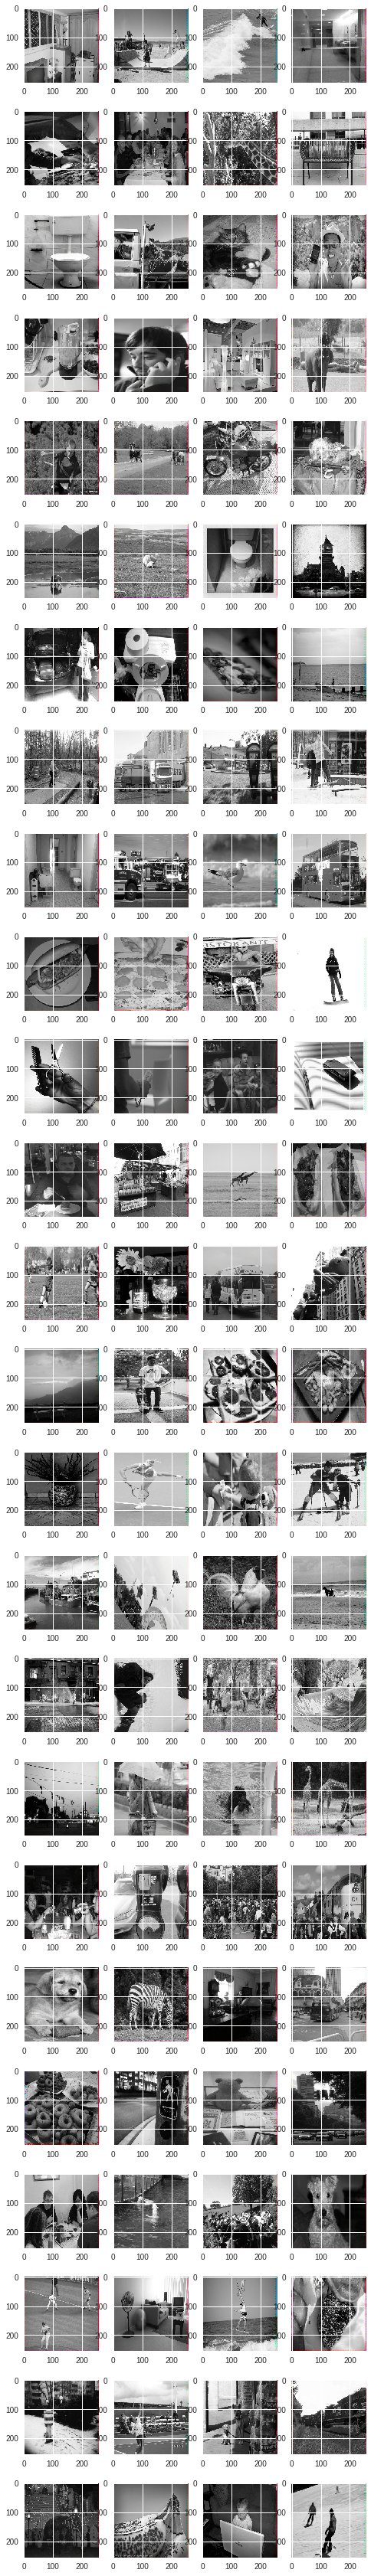

In [63]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

files = glob.glob("results/*.png")
files = sorted(files)

IMAGES_COLUMNS = 4
IMAGES_DISPLAY_ROWS = len(files)

plt.figure(figsize=(8, 64))

for i, file_name in enumerate(files):
    plt.subplot(len(files) // IMAGES_COLUMNS + 1, IMAGES_COLUMNS, i + 1)
    plt.axis('off')
    img = mpimg.imread(file_name)
    plt.title('Image: %i' % file_name)
    plt.imshow(img)